In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
from matplotlib import pyplot as plt
import os 
from openpyxl import load_workbook
import warnings
warnings.filterwarnings("ignore")

###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


In [2]:
directory = os.path.normpath(os.getcwd() + os.sep + os.pardir+ os.sep + os.pardir )
ois=directory+"/data/icedata/DataX_Rhoova_OIS_2025-01-20_2025-01-21_100510UTC.csv"
ois_data = pd.read_csv(ois)
ois_data.head(5)

,DataType,ValuationDate,Cutoff,RunningTimeStamp,Status,Currency,Index,Instrument,Tenor,TenorDate,PaymentFrequency,DayCountBasis,RateMid,DF,Zero
0,IR_CURVEOIS,2025-01-20,EOD,2025-01-21 1005 UTC,Succeeded,USD,SOFR,Swap,1W,2025-01-29,1Y,Actual/360,4.2960,0.99893,4.35402
1,IR_CURVEOIS,2025-01-20,EOD,2025-01-21 1005 UTC,Succeeded,USD,SOFR,Swap,2W,2025-02-05,1Y,Actual/360,4.2973,0.99809,4.35351
2,IR_CURVEOIS,2025-01-20,EOD,2025-01-21 1005 UTC,Succeeded,USD,SOFR,Swap,3W,2025-02-12,1Y,Actual/360,4.2988,0.99726,4.35319
3,IR_CURVEOIS,2025-01-20,EOD,2025-01-21 1005 UTC,Succeeded,USD,SOFR,Swap,1M,2025-02-24,1Y,Actual/360,4.3013,0.99583,4.35259
4,IR_CURVEOIS,2025-01-20,EOD,2025-01-21 1005 UTC,Succeeded,USD,SOFR,Swap,2M,2025-03-24,1Y,Actual/360,4.3045,0.99252,4.34864


In [3]:
#Fixed Definition
eurois={"settlementDays": 2,
 "intpMethod": "LINEAR",
 "currency": "EUR",
 "calendar": "TARGET",
 "dayCounter": "Actual365Fixed",
 "period": "1D",
 'index':"ESTR",
 'paymentlag':2,
 "usedates":False,
 "instruments": {
  "OIS": {"businessDayConvention": "Following",
   "dayCounter": "Actual360",
   "frequency": "Annual"}}}

In [4]:
ois_dict_lsf=[]
for index,row in ois_data.iterrows():
    ois_dict={}
    ois_dict["tenor"]=row["Tenor"]
    ois_dict["maturityDate"]=""
    ois_dict["value"]=row["RateMid"]/100
    ois_dict["valuationDate"]=row["ValuationDate"]
    ois_dict["currency"]=row["Currency"]
    ois_dict["instrument"]="OIS"
    ois_dict["settlementDate"]="2D"
    ois_dict["period"]="1D"
    ois_dict_lsf.append(ois_dict)


In [5]:
ois_df=pd.DataFrame(ois_dict_lsf)

In [6]:
yieldcurve =  {
    "valuationDate": "2025-01-20",
    "yieldCurve":eurois ,
    "yieldData": ois_df.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [7]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovayieldcurvedicts = {}
rhoovayieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovayieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovayieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    


In [8]:
estr=ois_data[ois_data["Index"]=="ESTR"]
ice_zeros=list(estr["Zero"])
ice_discountrates=list(estr["DF"])
ice_dates=list(estr["TenorDate"])

In [9]:
dates=[]
forwarddates= {}
iceyieldcurvezeros = {}
iceyieldcurvediscounts = {}
for i in range(0,len(ice_zeros)):
    iceyieldcurvezeros[datetime.strptime(ice_dates[i],'%Y-%m-%d').date()] =ice_zeros[i]
    iceyieldcurvediscounts[datetime.strptime(ice_dates[i],'%Y-%m-%d').date()] =ice_discountrates[i]


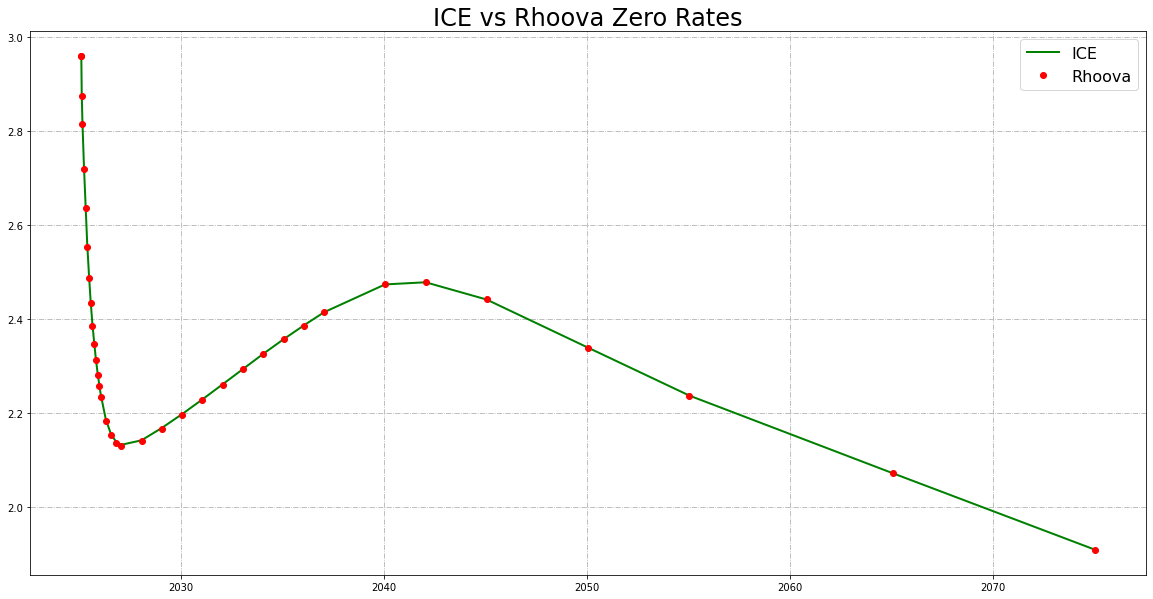

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())[1:]
y1 =ice_zeros
y2 = list(rhoovayieldcurvedicts.values())[1:]


ax.plot(x,y1, 'g', label='ICE', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=4)
#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.title("ICE vs Rhoova Zero Rates",fontsize = 24)
plt.show()

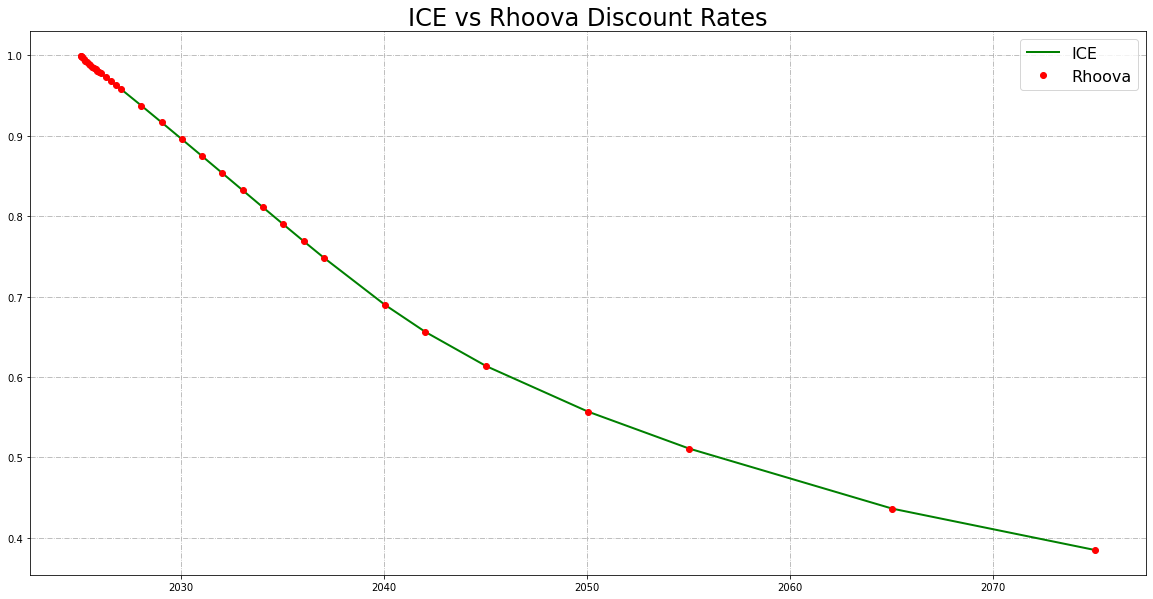

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())[1:]
y1 =ice_discountrates
y2 = list(rhoovayieldcurvediscounts.values())[1:]

ax.plot(x,y1, 'g', label='ICE', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=12)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.title("ICE vs Rhoova Discount Rates",fontsize = 24)
plt.show()

In [12]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','ICE ZR','Rhoova Discount Rate','ICE DR'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,iceyieldcurvezeros.get(key),rhoovayieldcurvediscounts.get(key),iceyieldcurvediscounts.get(key)])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+----------+----------------------+----------+
|  Maturity  | Rhoova ZeroRates |  ICE ZR  | Rhoova Discount Rate |  ICE DR  |
+------------+------------------+----------+----------------------+----------+
| 2025-01-22 |     2.958702     |   None   |          1           |   None   |
| 2025-01-29 |     2.958702     | 2.959000 |       0.999433       | 0.999270 |
| 2025-02-05 |     2.957863     | 2.958130 |       0.998866       | 0.998700 |
| 2025-02-12 |     2.874531     | 2.881970 |       0.998348       | 0.998190 |
| 2025-02-24 |     2.814621     | 2.822930 |       0.997459       | 0.997300 |
| 2025-03-24 |     2.718136     | 2.725820 |       0.995468       | 0.995310 |
| 2025-04-22 |     2.636747     | 2.643780 |       0.993520       | 0.993360 |
| 2025-05-22 |     2.553478     | 2.560140 |       0.991640       | 0.991480 |
| 2025-06-23 |     2.487323     | 2.493460 |       0.989695       | 0.989530 |
| 2025-07-22 |     2.433796     | 2.439550 |       0